# DeCET application to REMC T cell samples

In [1]:
import numpy as np
import torch
import scipy
import matplotlib.pyplot as plt
import sklearn.decomposition
from sklearn import svm
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from collections import defaultdict
from collections import Counter
from matplotlib import rcParams
import matplotlib.patches as mpatches
import seaborn
import os
import pandas as pd

seaborn.set(font='Arial')
plt.style.use('default')
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 11
rcParams['pdf.fonttype'] = 42
plt.rcParams.update({"text.color": 'k'})

import sys
sys.path.append('./')
import auxiliary_bed_functions as abf

date = '7_21_20' # Change this to today's date for output names.

input_dir = '../DeCET_REMC/'  # directory where the HOSVD files can be found
file_prefix = 'DeCET_REMC_Tcell_final' # prefix used for input files
output_dir = '../' # directory to write output

In [2]:
# Read in the projections from the tensor decomposition.
fp = open( input_dir + file_prefix + '_projections.txt', 'r')

index = []
projections = []
for line in fp:
    l = line.strip().split(':')
    index.append([int(l[0].split(',')[0]), int(l[0].split(',')[1])])
    projections.append(l[1].strip().split(','))

print(len(index), len(projections[0]))
n_pt = 8
n_as = 6
fp.close()

sample_proj = np.zeros((n_pt, n_as, len(projections[0])))

for k in range(0,len(projections)):
    sample_proj[index[k][0], index[k][1]] = projections[k]

48 48


In [3]:
# Full and reduced labels for the REMC data files used in this study.
# Colors for the different T cell types and assays.

row_colors = [(1.0,0.0,0.0,1.0), (1.0,0.0,0.0,1.0), (1.0,0.0,0.0,1.0), 
              (0.0,0.0,1.0,1.0), (0.0,0.0,1.0,1.0), (0.0,0.0,1.0,1.0),
              (0.0,1.0,0.0,1.0), (0.0,1.0,0.0,1.0)]

sample_labels = ['E038 Primary T helper naive cells from peripheral blood',
                 'E039 Primary T helper naive cells from peripheral blood',
                 'E047 Primary T CD8+ naive cells from peripheral blood',
                 'E037 Primary T helper memory cells from peripheral blood',
                 'E040 Primary T helper memory cells from peripheral blood',
                 'E048 Primary T CD8+ memory cells from peripheral blood',
                 'E041 Primary T helper cells PMA-I stimulated',
                 'E042 Primary T helper 17 cells PMA-I stimulated']

sample_labels_short = ['E038', 'E039', 'E047', 'E037',
                       'E040', 'E048', 'E041', 'E042']


assay_colors = [(51/255,70/255,0,1.0), (204/255,20/255,204/255,1.0), (60/255,168/255,80/255,1.0),
                (104/255,20/255,104/255,1.0), (204/255,102/255,0,1.0), (162/255,148/255,80/255,1.0)]

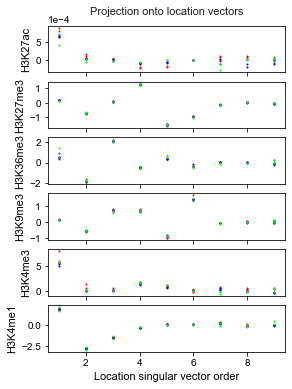

In [4]:
# Stacked projections
fig = plt.figure(figsize=(4.25,6.0))

n_proj = 9
assay_name = ['H3K27ac', 'H3K27me3', 'H3K36me3',
              'H3K9me3', 'H3K4me3', 'H3K4me1']
ax = []
for k in range(n_as):
    assay = k
    ax.append(fig.add_subplot(611+k))
    for i in range(n_pt):
        ax[k].plot(sample_proj[i, assay][0:n_proj],'.', markersize=2, c=row_colors[i])
        
    if(k == 0):
        plt.title('Projection onto location vectors',fontsize=11,y=1.1)
        
    ax[k].set_ylabel(assay_name[k],fontsize=11)
    
    ax[k].ticklabel_format(axis='y', style='sci', scilimits=(0.0,0.0))
    if(k < n_as-1): 
        plt.setp(ax[k].get_xticklabels(), visible=False)
    if(k != 0):
        ax[k].yaxis.get_offset_text().set_visible(False)
    
    if(k == n_as-1):
        ax[k].set_xlabel('Location singular vector order',fontsize=11)
        plt.setp(ax[k].get_xticklabels(), visible=True)
        plt.xticks([2*i+1 for i in range(int(n_proj/2))], [2*(i+1) for i in range(int(n_proj/2))])
    plt.setp(ax[k].get_xticklabels(), visible=True)
    plt.xticks([2*i+1 for i in range(int(n_proj/2))], [2*(i+1) for i in range(int(n_proj/2))])

In [5]:
def matrix_cosine(X, Y):
    """Calculates the matrix cosine distance.
    
    The cosine distance is computed for matching
    rows of the X and Y matrices and these values
    are summed over the rows.
    """
    K, N = X.shape
    dist = 0.0
    for k in range(K):
        dist += scipy.spatial.distance.cosine(X[k,:], Y[k,:])
    return dist

# Calculate the adjusted matrix cosine distance between 
# each pair of tissue samples.
# Select the number of location vectors to use for clustering.
use = [i for i in range(9)]
tissue_sample = np.copy(sample_proj[:,:,use])
print(tissue_sample.shape)

# Mean center the data across tissue samples for each assay.
for k in range(n_as):
    tissue_sample[:,k,:] = tissue_sample[:,k,:] - np.mean(tissue_sample[:,k,:], axis=0)

D = np.zeros((n_pt, n_pt))
for i in range(n_pt):
    for j in range(n_pt):
        D[i,j] = matrix_cosine(tissue_sample[i], tissue_sample[j])

(8, 6, 9)


In [6]:
# Reorder the assays to group marks associated with active and repressive
# gene transcription. This makes it easier to see trends in the projections.
reorder_assays=[0,4,5,2,1,3]

index_order = []
col_loc_color = []
single_col_color = []
col_assay = []
for l in range(len(use)):
    if(l % 2 == 0):
        single_col_color.append('k')
    else:
        single_col_color.append((0.5,0.5,0.5,1))
    for k in range(n_as):
        index_order.append(len(use)*k + l)
        col_assay.append(assay_colors[reorder_assays[k]])
    if(l % 2 == 0):
        for k in range(n_as):
            col_loc_color.append('k')
    else:
        for k in range(n_as):
            col_loc_color.append((0.5,0.5,0.5,1))

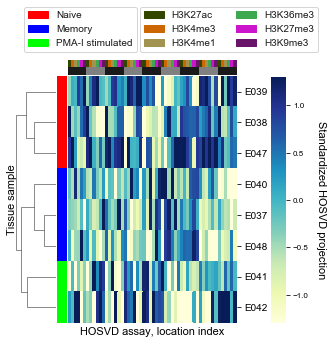

In [7]:
# Figure 6C (unsupervised hierarchical clustering of tissue samples)
legend_TT = [mpatches.Patch(color=c, label=l) for c,l in zip([(1.0,0.0,0.0,1.0), (0.0,0.0,1.0,1.0), (0.0,1.0,0.0,1.0)], ["Naive", "Memory", "PMA-I stimulated"])]
legend_assay = [mpatches.Patch(color=c, label=l) for c,l in zip([assay_colors[i] for i in reorder_assays], [assay_name[i] for i in reorder_assays])]

# Flatten the assay-location data into a vector that
# can be used for visualization.
full_sample_proj = np.concatenate((sample_proj[:,reorder_assays[0],np.sort(use)],
                                   sample_proj[:,reorder_assays[1],np.sort(use)],
                                   sample_proj[:,reorder_assays[2],np.sort(use)],
                                   sample_proj[:,reorder_assays[3],np.sort(use)],
                                   sample_proj[:,reorder_assays[4],np.sort(use)],
                                   sample_proj[:,reorder_assays[5],np.sort(use)]), axis=1)

# For each assay-location vector mean center and
# and scale to unit variance across samples.
full_scaled_proj = np.divide(full_sample_proj - np.mean(full_sample_proj, axis=0), np.std(full_sample_proj,axis=0))

# Obtain a hierarchical clustering using the adjusted
# matrix cosine distance and an average linkage.
linkage = hc.linkage(sp.distance.squareform(D), method='average')

# Make the cluster map. 
g = seaborn.clustermap(full_scaled_proj[:,index_order], row_linkage=linkage, cmap="YlGnBu",
                       row_cluster=True, col_cluster=False, robust=False, row_colors=row_colors,
                       col_colors=[col_assay, col_loc_color], xticklabels = [], figsize=(4,6),
                       vmin = np.percentile(full_scaled_proj.flatten(), 10, interpolation='nearest'),
                       vmax = np.percentile(full_scaled_proj.flatten(), 90, interpolation='nearest'),
                       yticklabels=sample_labels_short)

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_position([1.02,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('Standardized HOSVD projection', rotation=270, fontsize=11, labelpad=17)
        
l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.29,1.077), handles=legend_TT,
                       frameon=True, fontsize=10)
g.cax.legend(loc='lower left', bbox_to_anchor=(-9.5,1.08), handles=legend_assay,
                       frameon=True, fontsize=10, ncol=2)

g.ax_heatmap.set_xlabel('HOSVD assay, location index', fontsize=11)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=11)
g.ax_heatmap.yaxis.set_label_coords(-0.36,0.5)
g.savefig(output_dir + 'figures/figure6_panels/' + file_prefix + '_panelC_clustering_' +
          date + '.pdf', format='pdf')

In [8]:
np.sort(use) + 1

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

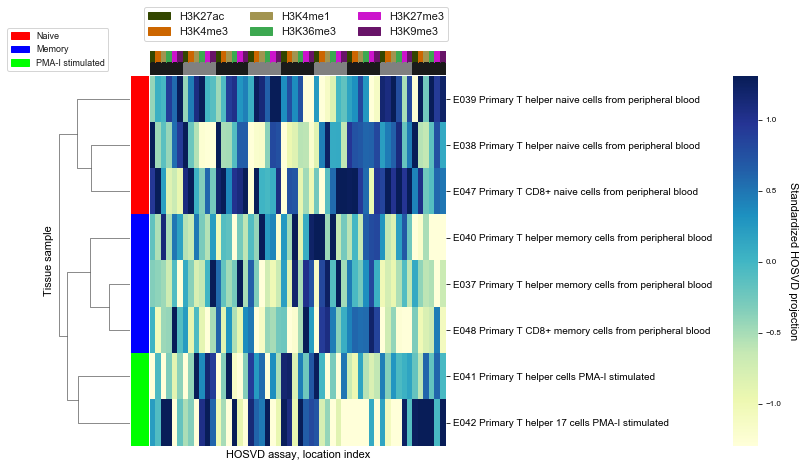

In [9]:
legend_TT = [mpatches.Patch(color=c, label=l) for c,l in zip([(1.0,0.0,0.0,1.0), (0.0,0.0,1.0,1.0), (0.0,1.0,0.0,1.0)], ["Naive", "Memory", "PMA-I stimulated"])]
legend_assay = [mpatches.Patch(color=c, label=l) for c,l in zip([assay_colors[i] for i in reorder_assays], [assay_name[i] for i in reorder_assays])]

# Flatten the assay-location data into a vector that
# can be used for visualization.
full_sample_proj = np.concatenate((sample_proj[:,reorder_assays[0],np.sort(use)],
                                   sample_proj[:,reorder_assays[1],np.sort(use)],
                                   sample_proj[:,reorder_assays[2],np.sort(use)],
                                   sample_proj[:,reorder_assays[3],np.sort(use)],
                                   sample_proj[:,reorder_assays[4],np.sort(use)],
                                   sample_proj[:,reorder_assays[5],np.sort(use)]), axis=1)

# For each assay-location vector mean center and
# and scale to unit variance across samples.
full_scaled_proj = np.divide(full_sample_proj - np.mean(full_sample_proj, axis=0),
                             np.std(full_sample_proj,axis=0))

# Obtain a hierarchical clustering using the adjusted
# matrix cosine distance and an average linkage.
linkage = hc.linkage(sp.distance.squareform(D), method='average')

# Make the cluster map. 
g = seaborn.clustermap(full_scaled_proj[:,index_order], row_linkage=linkage, cmap="YlGnBu",
                       row_cluster=True, col_cluster=False, robust=False, row_colors=row_colors,
                       col_colors=[col_assay, col_loc_color], xticklabels = [], figsize=(7,9),
                       vmin = np.percentile(full_scaled_proj.flatten(), 10, interpolation='nearest'),
                       vmax = np.percentile(full_scaled_proj.flatten(), 90, interpolation='nearest'),
                       yticklabels=sample_labels)

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_position([1.47,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('Standardized HOSVD projection', rotation=270, fontsize=11, labelpad=17)
        
l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.5,1.0), handles=legend_TT,
                       frameon=True, fontsize=9)
g.cax.legend(loc='lower left', bbox_to_anchor=(-23.6,1.08), handles=legend_assay,
                       frameon=True, fontsize=11, ncol=3)

g.ax_heatmap.set_xlabel('HOSVD assay, location index', fontsize=11)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=11)
g.ax_heatmap.yaxis.set_label_coords(-0.36,0.5)

In [10]:
# Load in the decomposition of the genomic location space.
U_l = torch.load(input_dir + file_prefix + '_factor_matrix_2.pt', map_location='cpu').numpy()

L_genome = U_l.shape[0]
print(U_l.shape)

(1440549, 48)


In [11]:
# The genomic bins used for the hg19 genome. chrY is 
# removed from the data before the HOSVD. Since chrY is
# at the end of the chromosome list used, this is
# not a problem.
chr_list = abf.getChrList()
chr_length = {'chrY': 59373566, 'chrX': 155270560, 'chr13': 115169878,
              'chr12': 133851895, 'chr11': 135006516, 'chr10': 135534747,
              'chr17': 81195210, 'chr16': 90354753, 'chr15': 102531392,
              'chr14': 107349540, 'chr19': 59128983, 'chr18': 78077248,
              'chrM': 16571, 'chr22': 51304566, 'chr20': 63025520,
              'chr21': 48129895, 'chr7': 159138663, 'chr6': 171115067,
              'chr5': 180915260, 'chr4': 191154276, 'chr3': 198022430,
              'chr2': 243199373, 'chr1': 249250621, 'chr9': 141213431,
              'chr8': 146364022}
bin_size = 2000

genomic_bin = [[] for l in range(0,1547874)]
counter = 0
for chrom in chr_list:
    for l in range(0, int(np.ceil(chr_length[chrom]/bin_size))+1):
        genomic_bin[counter] = [chrom, l*bin_size, (l+1)*bin_size]
        counter += 1
print(genomic_bin[72537])
print(counter)

['chr1', 145074000, 145076000]
1547874


In [12]:
# Get the bins (location vector components representing genomic regions)
# that are significantly non-zero for the location vector that separates
# the conditions.

# Select the location vector of interest (zero indexed).
loc_vec = 6

# Set the threshold for a vector component to be considered significant.
# The empirical distribution of component values from all vectors is used
# to set the threshold.

cut = np.percentile(np.absolute(U_l), 99.9, interpolation='nearest')

significant_pos = []
significant_neg = []
for i in range(L_genome):
    if(U_l[i,loc_vec] > cut):
        significant_pos.append(i)
    elif(U_l[i,loc_vec] < -cut):
        significant_neg.append(i)
        
print(len(significant_pos), 'positive')
print(len(significant_neg), 'negative')

# Save the regions exhibiting epigenetic alterations 
# between leiomyoma and myometrium. 1-based indexing
# is used for the file names.

output_pos = open(output_dir + 'region_files/' + file_prefix + '_pos_loc' + str(loc_vec+1) + '.txt','w+')

for l in range(0,len(significant_pos)):
            output_pos.write('{}\t{}\t{}\n'.format(genomic_bin[significant_pos[l]][0], genomic_bin[significant_pos[l]][1], genomic_bin[significant_pos[l]][2]))     
output_pos.close()

output_neg = open(output_dir + 'region_files/' + file_prefix + '_neg_loc' + str(loc_vec+1) + '.txt','w+')

for l in range(0,len(significant_neg)):
            output_neg.write('{}\t{}\t{}\n'.format(genomic_bin[significant_neg[l]][0], genomic_bin[significant_neg[l]][1], genomic_bin[significant_neg[l]][2]))
output_neg.close()

1254 positive
2324 negative


## Jaccard index clustering for this dataset

broadPeak files were obtained for each sample for each of the 6 histone modifications from https://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/broadPeak/

For each histone modifcation, the pairwise Jaccard index for samples i and j was obtained using

bedtools jaccard -a i -b j

The pairwise similarity matrix for each histone modification was saved as a tab separated text file with the Jaccard index for sample i and j saved as the ith line and jth column entry in the file. The samples are ordered according to the sample labels provided above.

In [13]:
# Read the Jaccard similarity matrix for a single histone.
# The samples are ordered according to the labels above.
similarity_matrix = pd.read_csv(input_dir + 'DeCET_REMC_Tcell_H3K4me1_broadPeak_Jaccard.txt',
                                delimiter='\t', header=None, index_col=None)

In [14]:
similarity_matrix.iloc[:,:-1]

,0,1,2,3,4,5,6,7
0,1.000000,0.488386,0.525208,0.513285,0.507178,0.436133,0.547323,0.441129
1,0.488386,1.000000,0.521134,0.495235,0.490658,0.433074,0.558467,0.437126
2,0.525208,0.521134,1.000000,0.529493,0.528111,0.451936,0.582592,0.460037
3,0.513285,0.495235,0.529493,1.000000,0.556100,0.456045,0.577762,0.485777
4,0.507178,0.490658,0.528111,0.556100,1.000000,0.433164,0.571265,0.484712
5,0.436133,0.433074,0.451936,0.456045,0.433164,1.000000,0.474478,0.397084
6,0.547323,0.558467,0.582592,0.577762,0.571265,0.474478,1.000000,0.503930
7,0.441129,0.437124,0.460037,0.485777,0.484709,0.397084,0.503930,1.000000


In [15]:
# The Jaccard similarity matrix must be symmetric for clustering. 
# There are small differences in the Jaccard index calculated by 
# switching the file order. This is corrected here by setting the
# entries above the diagonal to the corresponding entries of the
# transposed similarity matrix.
similarity_matrix_corrected = np.copy(similarity_matrix.values[:,:-1])
for i in range(similarity_matrix_corrected.shape[0]):
    for j in range(similarity_matrix_corrected.shape[1]):
        similarity_matrix_corrected[i,j] = similarity_matrix_corrected[j,i]
del similarity_matrix

In [16]:
pd.DataFrame(similarity_matrix_corrected)

,0,1,2,3,4,5,6,7
0,1.000000,0.488386,0.525208,0.513285,0.507178,0.436133,0.547323,0.441129
1,0.488386,1.000000,0.521134,0.495235,0.490658,0.433074,0.558467,0.437124
2,0.525208,0.521134,1.000000,0.529493,0.528111,0.451936,0.582592,0.460037
3,0.513285,0.495235,0.529493,1.000000,0.556100,0.456045,0.577762,0.485777
4,0.507178,0.490658,0.528111,0.556100,1.000000,0.433164,0.571265,0.484709
5,0.436133,0.433074,0.451936,0.456045,0.433164,1.000000,0.474478,0.397084
6,0.547323,0.558467,0.582592,0.577762,0.571265,0.474478,1.000000,0.503930
7,0.441129,0.437124,0.460037,0.485777,0.484709,0.397084,0.503930,1.000000


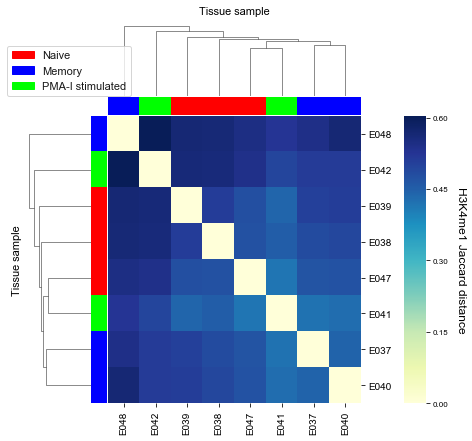

In [17]:
# Cluster the tissue samples based on the Jaccard similarity matrix for 
# a given histone modification. 
legend_TT = [mpatches.Patch(color=c, label=l) for c,l in zip([(1.0,0.0,0.0,1.0), (0.0,0.0,1.0,1.0), (0.0,1.0,0.0,1.0)], ["Naive", "Memory", "PMA-I stimulated"])]
linkage = hc.linkage(sp.distance.squareform(1 - similarity_matrix_corrected), method='complete')

g = seaborn.clustermap(1 - similarity_matrix_corrected, row_linkage=linkage, col_linkage=linkage, cmap="YlGnBu", 
                       row_cluster=True, col_cluster=True, robust=False, row_colors=row_colors, col_colors=row_colors,
                       xticklabels=sample_labels_short, yticklabels=sample_labels_short, figsize=(6,7))

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=10, rotation=90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=10, rotation=0)
g.cax.set_position([1.0,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('H3K4me1 Jaccard distance', rotation=270, fontsize=12, labelpad=17)

l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.42,1.05), handles=legend_TT,
                       frameon=True, fontsize=11)

g.ax_heatmap.set_xlabel('Tissue sample', fontsize=11)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=11)
g.ax_heatmap.xaxis.set_label_coords(0.5,1.38)
g.ax_heatmap.yaxis.set_label_coords(-0.38,0.5)

In [18]:
def quantile_normalize(*args):
    """Quantile normalize a set of equal length lists.
    
    The lists are assumed to be of the same length.
    Quantile normalization is performed by sorting
    each of the lists and taking the mean of the
    sorted lists. The entry with the greatest value 
    for each list is then set to the mean of the 
    greatest values from all the lists. This is repeated
    for the 2nd greatest entry, and so on.
    """
    K = len(args)
    X_argsort = np.zeros((K, len(args[0])), dtype=np.int)
    q_norm = np.zeros(len(args[0]))
    X_qnorm = np.zeros((K, len(args[0])))
    
    for i in range(K):
        q_norm += np.sort(args[i])
    q_norm /= K
    
    for i in range(K):
        X_argsort[i] = np.argsort(args[i])
        for j in range(len(args[i])):
            X_qnorm[i, X_argsort[i,j]] = q_norm[j]
    
    return [X_qnorm[i,:] for i in range(K)]

In [19]:
# Cluster using a combined Jaccard similarity.
# Read the Jaccard index similarity matrix for each histone modification.
jaccard_similarity_H3K27ac = pd.read_csv(input_dir + 'DeCET_REMC_Tcell_H3K27ac_broadPeak_Jaccard.txt', sep = '\t',
                                header = None, index_col = None)
jaccard_similarity_H3K27ac = pd.DataFrame(jaccard_similarity_H3K27ac.values[:,:-1])

jaccard_similarity_H3K4me3 = pd.read_csv(input_dir + 'DeCET_REMC_Tcell_H3K4me3_broadPeak_Jaccard.txt', sep = '\t',
                                header = None, index_col = None)
jaccard_similarity_H3K4me3 = pd.DataFrame(jaccard_similarity_H3K4me3.values[:,:-1])

jaccard_similarity_H3K4me1 = pd.read_csv(input_dir + 'DeCET_REMC_Tcell_H3K4me1_broadPeak_Jaccard.txt', sep = '\t',
                                header = None, index_col = None)
jaccard_similarity_H3K4me1 = pd.DataFrame(jaccard_similarity_H3K4me1.values[:,:-1])

jaccard_similarity_H3K27me3 = pd.read_csv(input_dir + 'DeCET_REMC_Tcell_H3K27me3_broadPeak_Jaccard.txt', sep = '\t',
                                header = None, index_col = None)
jaccard_similarity_H3K27me3 = pd.DataFrame(jaccard_similarity_H3K27me3.values[:,:-1])

jaccard_similarity_H3K9me3 = pd.read_csv(input_dir + 'DeCET_REMC_Tcell_H3K9me3_broadPeak_Jaccard.txt', sep = '\t',
                                header = None, index_col = None)
jaccard_similarity_H3K9me3 = pd.DataFrame(jaccard_similarity_H3K9me3.values[:,:-1])

jaccard_similarity_H3K36me3 = pd.read_csv(input_dir + 'DeCET_REMC_Tcell_H3K36me3_broadPeak_Jaccard.txt', sep = '\t',
                                header = None, index_col = None)
jaccard_similarity_H3K36me3 = pd.DataFrame(jaccard_similarity_H3K36me3.values[:,:-1])

In [20]:
# Obtain a combined similarity by summing the Jaccard
# similarities for each histone modification.
similarity_matrix_combined = jaccard_similarity_H3K27ac.values + \
                             jaccard_similarity_H3K4me3.values + \
                             jaccard_similarity_H3K4me1.values + \
                             jaccard_similarity_H3K27me3.values + \
                             jaccard_similarity_H3K9me3.values + \
                             jaccard_similarity_H3K36me3.values

In [21]:
pd.DataFrame(similarity_matrix_combined)

,0,1,2,3,4,5,6,7
0,6.000000,2.068946,1.948239,1.909435,1.963061,1.807834,2.224192,1.954485
1,2.068950,6.000000,2.125659,2.067234,2.049911,1.921228,2.780007,2.319098
2,1.948239,2.125656,6.000000,1.912967,2.004097,1.820354,2.306042,2.009166
3,1.909437,2.067234,1.912969,6.000000,2.075308,1.923010,2.297569,2.059189
4,1.963064,2.049910,2.004099,2.075308,6.000000,1.889760,2.333827,2.067805
5,1.807835,1.921226,1.820354,1.923009,1.889760,6.000000,2.080108,1.872099
6,2.224197,2.780012,2.306049,2.297574,2.333832,2.080114,6.000000,2.579020
7,1.954487,2.319094,2.009168,2.059189,2.067801,1.872099,2.579012,6.000000


In [22]:
# Correct entries that are not symmetric using the same approach
# as above and take the average similarity across histones.
for i in range(similarity_matrix_combined.shape[0]):
    for j in range(similarity_matrix_combined.shape[1]):
        similarity_matrix_combined[i,j] = similarity_matrix_combined[j,i]
similarity_matrix_combined /= 6.0

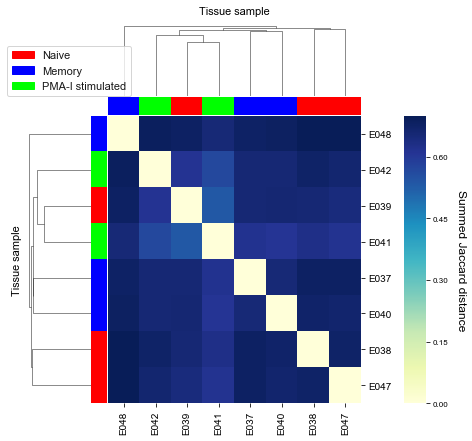

In [23]:
# Cluster based on the Jaccard similarity summed across histones.
legend_TT = [mpatches.Patch(color=c, label=l) for c,l in zip([(1.0,0.0,0.0,1.0), (0.0,0.0,1.0,1.0), (0.0,1.0,0.0,1.0)], ["Naive", "Memory", "PMA-I stimulated"])]
linkage = hc.linkage(sp.distance.squareform(1 - similarity_matrix_combined), method='complete')

g = seaborn.clustermap(1 - similarity_matrix_combined, row_linkage=linkage, col_linkage=linkage, cmap="YlGnBu", 
                       row_cluster=True, col_cluster=True, robust=False, row_colors=row_colors, col_colors=row_colors,
                       xticklabels=sample_labels_short, yticklabels=sample_labels_short, figsize=(6,7))

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=10, rotation=90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=10, rotation=0)
g.cax.set_position([1.0,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('Summed Jaccard distance', rotation=270, fontsize=12, labelpad=17)

l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.42,1.05), handles=legend_TT,
                       frameon=True, fontsize=11)

g.ax_heatmap.set_xlabel('Tissue sample', fontsize=11)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=11)
g.ax_heatmap.xaxis.set_label_coords(0.5,1.38)
g.ax_heatmap.yaxis.set_label_coords(-0.38,0.5)

In [24]:
# Apply the quantile normalization to the Jaccard
# similarities for each histone.
jaccard_similarity_qnorm = quantile_normalize(jaccard_similarity_H3K27ac.values.flatten(),
                                              jaccard_similarity_H3K4me3.values.flatten(),
                                              jaccard_similarity_H3K4me1.values.flatten(),
                                              jaccard_similarity_H3K27me3.values.flatten(),
                                              jaccard_similarity_H3K9me3.values.flatten(),
                                              jaccard_similarity_H3K36me3.values.flatten())

for k in range(n_as):
    jaccard_similarity_qnorm[k] = np.reshape(jaccard_similarity_qnorm[k], jaccard_similarity_H3K27ac.shape)

In [25]:
# Obtain a combined similarity by summing the
# quantile normalized similarities across histones.
similarity_matrix_combined_qnorm = sum(jaccard_similarity_qnorm)

In [26]:
# Correct entries that are not symmetric using the same approach
# as above and take the average similarity across histones.
for i in range(similarity_matrix_combined_qnorm.shape[0]):
    for j in range(similarity_matrix_combined_qnorm.shape[1]):
        similarity_matrix_combined_qnorm[i,j] = similarity_matrix_combined_qnorm[j,i]
similarity_matrix_combined_qnorm /= 6.0

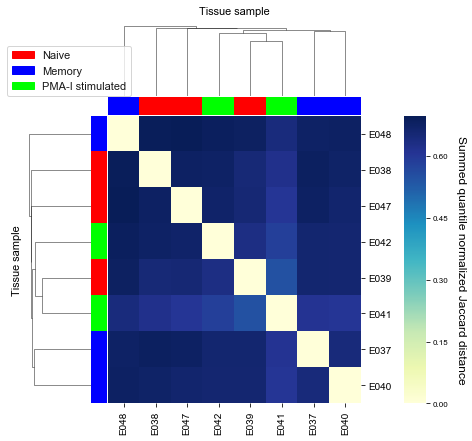

In [27]:
# Cluster based on the quantile normalized Jaccard 
# similarity summed across histones. 
legend_TT = [mpatches.Patch(color=c, label=l) for c,l in zip([(1.0,0.0,0.0,1.0), (0.0,0.0,1.0,1.0), (0.0,1.0,0.0,1.0)], ["Naive", "Memory", "PMA-I stimulated"])]
linkage = hc.linkage(sp.distance.squareform(1 - similarity_matrix_combined_qnorm), method='complete')

g = seaborn.clustermap(1 - similarity_matrix_combined_qnorm, row_linkage=linkage, col_linkage=linkage, cmap="YlGnBu", 
                       row_cluster=True, col_cluster=True, robust=False, row_colors=row_colors, col_colors=row_colors,
                       xticklabels=sample_labels_short, yticklabels=sample_labels_short, figsize=(6,7))

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=10, rotation=90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=10, rotation=0)
g.cax.set_position([1.0,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('Summed quantile normalized Jaccard distance', rotation=270, fontsize=12, labelpad=17)

l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.42,1.05), handles=legend_TT,
                       frameon=True, fontsize=11)

g.ax_heatmap.set_xlabel('Tissue sample', fontsize=11)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=11)
g.ax_heatmap.xaxis.set_label_coords(0.5,1.38)
g.ax_heatmap.yaxis.set_label_coords(-0.38,0.5)

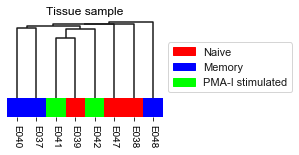

In [28]:
# Figure 8C (Jaccard index clustering of REMC T cell sampels)
# Plot the dendrogram for the combined quantile normalized clustering.
fig = plt.figure(figsize=(1.8,5.5))
ax_den = fig.add_axes([0.0,0.05,1.2,0.2])

linkage = hc.linkage(sp.distance.squareform(1 - similarity_matrix_combined_qnorm), method='complete')

d = scipy.cluster.hierarchy.dendrogram(linkage, labels=None, leaf_rotation=0, no_labels=True,
                                       orientation="top", color_threshold=0, above_threshold_color='k')

ax_den.set(frame_on=False)
ax_den.xaxis.set_ticks([])
ax_den.yaxis.set_ticks([])
ax_den.set_xlabel('Tissue sample', fontsize=12)
ax_den.xaxis.set_label_position('top') 

ax_col=fig.add_axes([0.0,0.0,1.2,0.05])

for i, leaf in enumerate(scipy.cluster.hierarchy.leaves_list(linkage)):
    ax_col.add_patch(mpatches.Rectangle((i/n_pt,0.0), 1.0/n_pt, 1.0,  ec=None, fc=row_colors[leaf]))

ax_col.yaxis.set_ticks([])
ax_col.xaxis.set_ticks_position('bottom')
ax_col.xaxis.set_ticks([i/n_pt + 0.5/n_pt for i in range(n_pt)])
ax_col.xaxis.set_ticklabels([sample_labels_short[i] for i in scipy.cluster.hierarchy.leaves_list(linkage)], fontsize=10, rotation=270, ha='center')
ax_col.set(frame_on=False)

legend_TT = [mpatches.Patch(color=c, label=l) for c,l in zip([(1.0,0.0,0.0,1.0), (0.0,0.0,1.0,1.0), (0.0,1.0,0.0,1.0)], ["Naive", "Memory", "PMA-I stimulated"])]
ax_col.legend(loc='lower left', bbox_to_anchor=(1.0,1.0), handles=legend_TT,
              frameon=True, fontsize=11)

ax_col.set_xlim(ax_col.get_xlim()[::-1])
ax_den.set_xlim(ax_den.get_xlim()[::-1])

g.savefig(output_dir + 'figures/figure8_panels/' + file_prefix + '_panelC_Jaccard_clustering_' +
          date + '.pdf', format='pdf', bbox_inches='tight')